In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.optimize import least_squares

# Volume ratio

Let's start by reading the trial data.

In [2]:
methods = pd.read_csv('methods.csv', index_col='id')
methods.tail()

,description,notes
id,,
5,Brass manifold (2 phases),NaN
6,Brass manifold (3 phases),Started opening all valves before each trial
7,Positive pressure,NaN
8,Brass manifold (2 phases),After re-assembly
9,Brass manifold (2 phases),Automatic version


In [3]:
samples = pd.read_csv('samples.csv', index_col='id')
samples.tail()

,date,weight,volume,bag_id,grinder_cal_id,grind_setting,shot_id,depth_id,method_id,description,notes
id,,,,,,,,,,,
990,2025-02-15,0.00,0.00,NaN,NaN,NaN,NaN,NaN,9,Empty,NaN
991,2025-02-15,269.35,34.05,NaN,NaN,NaN,NaN,NaN,9,75 balls (old),NaN
992,2025-02-16,18.32,NaN,159.0,14.0,2.4,1987.0,1462.0,9,Irineo Ramirez (2.40) ground,NaN
993,2025-02-16,0.00,0.00,NaN,NaN,NaN,NaN,NaN,9,Empty,NaN
994,2025-02-16,269.20,34.05,NaN,NaN,NaN,NaN,NaN,9,75 balls (old),NaN


In [4]:
trials = pd.read_csv('trials.csv', index_col='id')
trials.tail()

,sample_id,filename
id,,
2975,993,trials/trial-2975.csv
2976,993,trials/trial-2976.csv
2977,994,trials/trial-2977.csv
2978,994,trials/trial-2978.csv
2979,994,trials/trial-2979.csv


There are a couple of incomplete trials here. Let's drop them.

In [5]:
trials = trials[[i not in [1451,1507,1525] for i in trials.index]]

For these experiments, two measurement technique were used. In the first technique, we have two chambers separated by a valve. One chamber is empty and the other chamber contains our sample. We start with a partial vacuum in the empty chamber and atmospheric pressure in the sample chamber, then we open the valve between the two chambers and measure the resulting change in pressure. Here's a typical plot showing the pressure change in the two chambers.

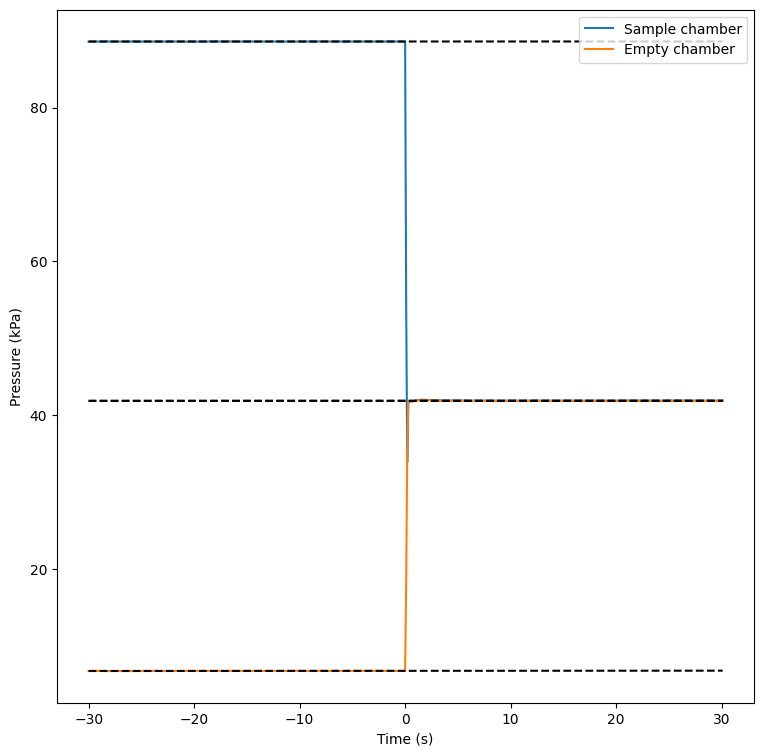

In [6]:
def pressure_func(x, m, b):
    return m * x + b

# Read the data
data = pd.read_csv(trials.loc[884].filename, header=0)

# Get linear fits
xs = data.time.values[data.time.values < -10]
ys = data.pres_1.values[data.time.values < -10]
fit_1 = curve_fit(pressure_func, xs, ys)

ys = data.pres_2.values[data.time.values < -10]
fit_2 = curve_fit(pressure_func, xs, ys)

xs = data.time.values[(data.time.values > 10) & (data.time.values <= 30)]
ys = data.pres_1.values[(data.time.values > 10) & (data.time.values <= 30)]
fit_1_prime = curve_fit(pressure_func, xs, ys)

xs = data.time.values[(data.time.values > 10) & (data.time.values <= 30)]
ys = data.pres_2.values[(data.time.values > 10) & (data.time.values <= 30)]
fit_2_prime = curve_fit(pressure_func, xs, ys)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot data
ax.plot(data.time, data.pres_1, label='Sample chamber')
ax.plot(data.time, data.pres_2, label='Empty chamber')

# Plot the fits
ax.plot(data.time, pressure_func(data.time, *fit_1[0]), 'k--')
ax.plot(data.time, pressure_func(data.time, *fit_1_prime[0]), 'k--')

ax.plot(data.time, pressure_func(data.time, *fit_2[0]), 'k--')
ax.plot(data.time, pressure_func(data.time, *fit_2_prime[0]), 'k--')

# Set axis labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pressure (kPa)')

# Draw legend
ax.legend(loc='upper right')

By fitting lines to the three equilibrium states, we can determine the change in pressure at the moment the valve is opened, and thus the ratio of the sample chamber volume to the empty chamber volume.

In [7]:
def vol_ratio_two_sensors(filename):
    # Read the data
    data = pd.read_csv(filename, header=0)
    
    # Get linear fits
    xs = data.time.values[data.time.values < -10]
    ys = data.pres_1.values[data.time.values < -10]
    pres_1 = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    ys = data.pres_2.values[data.time.values < -10]
    pres_2 = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    xs = data.time.values[(data.time.values > 10) & (data.time.values <= 30)]
    ys = data.pres_1.values[(data.time.values > 10) & (data.time.values <= 30)]
    pres_1_prime = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    ys = data.pres_2.values[(data.time.values > 10) & (data.time.values <= 30)]
    pres_2_prime = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    r = -(pres_2_prime - pres_2) / (pres_1_prime - pres_1)
    
    sigma_p = 0.0079
    sigma_r = np.sqrt(2 * (1 / (pres_2_prime - pres_2)**2 + 1 / (pres_1_prime - pres_1)**2)) * sigma_p * r

    # Volume ratio from y-intercepts
    return (r, sigma_r)


For the trial shown above, we have:

In [8]:
vol_ratio_two_sensors(trials.loc[884].filename)

(np.float64(0.7513571850353837), np.float64(0.00029923042281477))

That is, the sample chamber has a volume $0.75136 \pm 0.00030$ times the volume of the empty chamber. The error calculation is based on the 0.0079 kPa resolution of the HSCDANN015PA2A3 sensor used in these experiments. Note that this isn't representative of the absolute accuracy of the sensor, but the assumption here is that offset and scaling errors errors common to both sensors will be cancelled out in the calculation of volume ratio.

The second technique used for these experiments uses a single chamber. In this technique, the sample is put into this chamber, then the volume is changed by some fixed amount. Again we measure the resulting change in pressure, this time using a single sensor. Here is a typical plot showing the change in pressure for a single chamber experiment.

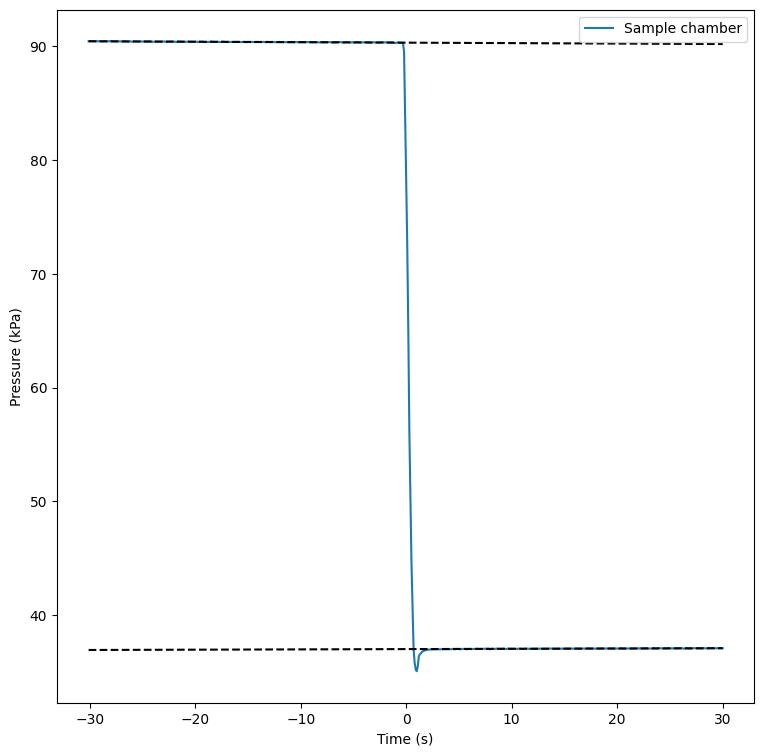

In [9]:
# Read the data
data = pd.read_csv(trials.loc[120].filename, header=0)

# Get linear fits
xs = data.time.values[data.time.values < -10]
ys = data.pres_1.values[data.time.values < -10]
fit_1 = curve_fit(pressure_func, xs, ys)

xs = data.time.values[data.time.values > 10]
ys = data.pres_1.values[data.time.values > 10]
fit_2 = curve_fit(pressure_func, xs, ys)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Plot data
ax.plot(data.time, data.pres_1, label='Sample chamber')

# Plot the fits
ax.plot(data.time, pressure_func(data.time, *fit_1[0]), 'k--')
ax.plot(data.time, pressure_func(data.time, *fit_2[0]), 'k--')

# Set axis labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pressure (kPa)')

# Draw legend
ax.legend(loc='upper right')

Again we can fit lines to the equilibrium states in order to determine the change in pressure when the chamber volume is changed, and thus the ratio of the sample chamber volumes.

In [10]:
def vol_ratio_one_sensor(filename):
    # Read the data
    data = pd.read_csv(filename, header=0)

    # Get linear fits
    xs = data.time.values[data.time.values < -10]
    ys = data.pres_1.values[data.time.values < -10]
    pres_1 = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    xs = data.time.values[data.time.values > 10]
    ys = data.pres_1.values[data.time.values > 10]
    pres_1_prime = pressure_func(0, *curve_fit(pressure_func, xs, ys)[0])

    r = -pres_1_prime / (pres_1_prime - pres_1)
    
    sigma_p = 0.0079
    sigma_r = np.sqrt(2 * (1 / pres_1_prime**2 + 1 / (pres_1_prime - pres_1)**2)) * sigma_p * r

    # Volume ratio from y-intercepts
    return (r, sigma_r)

For the trial shown above we have:

In [11]:
vol_ratio_one_sensor(trials.loc[120].filename)

(np.float64(0.6942124411287496), np.float64(0.0002551118773979617))

Let's associate each measurement method with one of these two techniques.

In [12]:
vol_ratio_methods = {1: vol_ratio_one_sensor,
                     2: vol_ratio_two_sensors,
                     3: vol_ratio_one_sensor,
                     4: vol_ratio_two_sensors,
                     5: vol_ratio_two_sensors,
                     6: vol_ratio_two_sensors,
                     7: vol_ratio_two_sensors,
                     8: vol_ratio_two_sensors,
                     9: vol_ratio_two_sensors}

Now we can calculate the volume ratio for each trial.

In [13]:
def row_func(row):
    method_id = samples.loc[row.sample_id].method_id
    row['vol_ratio'], row['sigma_vol_ratio'] = vol_ratio_methods[method_id](row.filename)
    return row

trials = trials.apply(row_func, axis=1)
trials.tail()

,sample_id,filename,vol_ratio,sigma_vol_ratio
id,,,,
2975,993,trials/trial-2975.csv,0.996081,0.000515
2976,993,trials/trial-2976.csv,0.995842,0.000515
2977,994,trials/trial-2977.csv,0.735132,0.000390
2978,994,trials/trial-2978.csv,0.733623,0.000391
2979,994,trials/trial-2979.csv,0.733760,0.000392


# Outliers

Let's look for outliers in our calibration measurements. The calibration samples are the ones for which a volume has been specified.

In [14]:
# Get samples with valid volume
samples_w_vol = samples.dropna(subset='volume')

Now we plot the volume ratio for each trial associated with these samples.

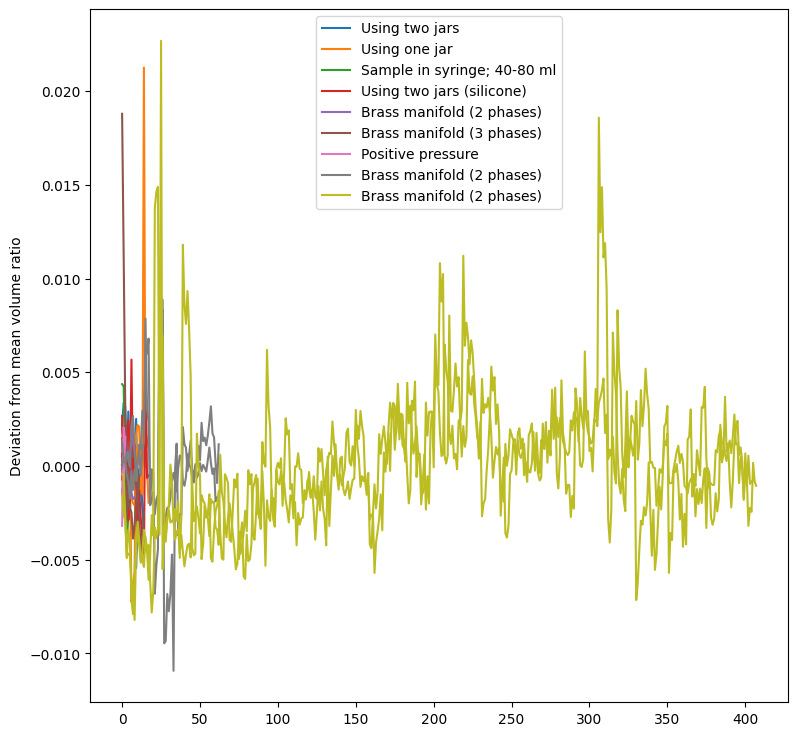

In [15]:
def plot_calibration():
    # Get color map
    method_colors = plt.colormaps['tab10'].colors
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(9,9))
    fig.patch.set_facecolor('white')
    
    for i, method_id in enumerate(samples.method_id.unique()):
        # Get samples for this method
        samples_this_method = samples_w_vol[samples_w_vol.method_id == method_id]
        
        # Initialize label
        label = methods.loc[method_id].description
    
        for description in samples_this_method.description.unique():
            # Get samples with this description
            samples_this_desc = samples_this_method[samples_this_method.description == description]
    
            # Get trials for these samples
            trials_this_desc = trials[[s in samples_this_desc.index for s in trials.sample_id]]
            
            # Get volume ratios
            vol_ratios = trials_this_desc.vol_ratio
            
            # Get mean value of volume ratio
            mean_vol_ratio = vol_ratios.mean()
            
            # Plot deviation from mean
            ax.plot(range(len(vol_ratios)), vol_ratios - mean_vol_ratio,
                    label=label, color=method_colors[i])
            
            # Reset label
            label = None
    
    # Set axis labels
    ax.set_ylabel('Deviation from mean volume ratio')
    
    # Draw the legend
    plt.legend()

# Plot calibrations
plot_calibration()

There are a few outliers on the left. These are trials #93, #455, #456, and #457.

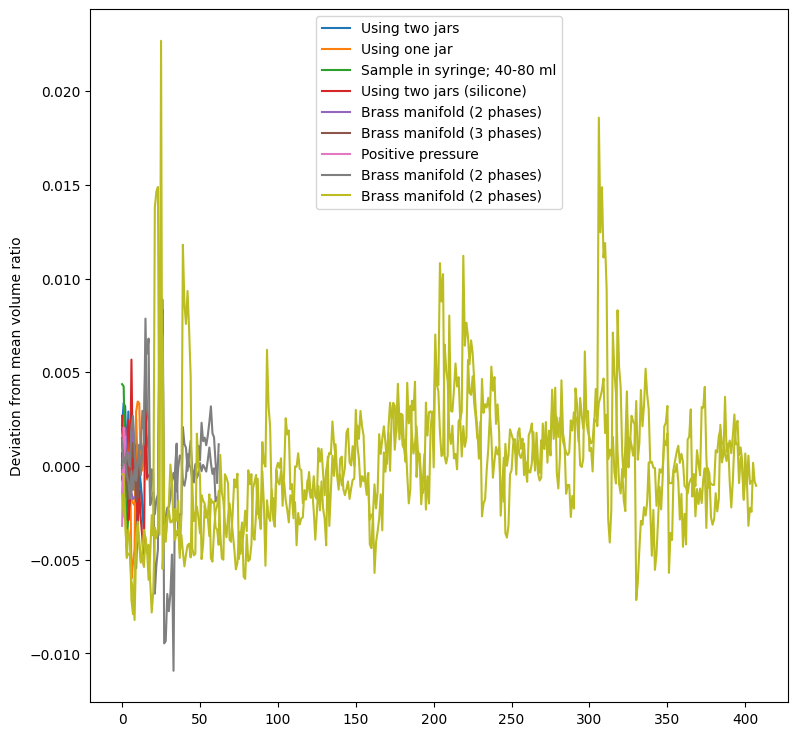

In [16]:
# Drop the trials
trials = trials.drop([93, 455, 456, 457])

# Plot calibrations
plot_calibration()

On the right, we have some wild swings in measurements using method 8. These occurred after a period of about 6 months without using the apparatus. I think what happened here is that I changed the way I handled the apparatus, so that I was touching the pressure sensor more than I used to and creating temperature-related errors. When I stopped touching the sensor, in the last 6 trials, the measurements seemed to become more stable.

/tmp/ipykernel_12946/3238877015.py:7: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  indices_to_drop = trials[id_mask & cal_mask].index


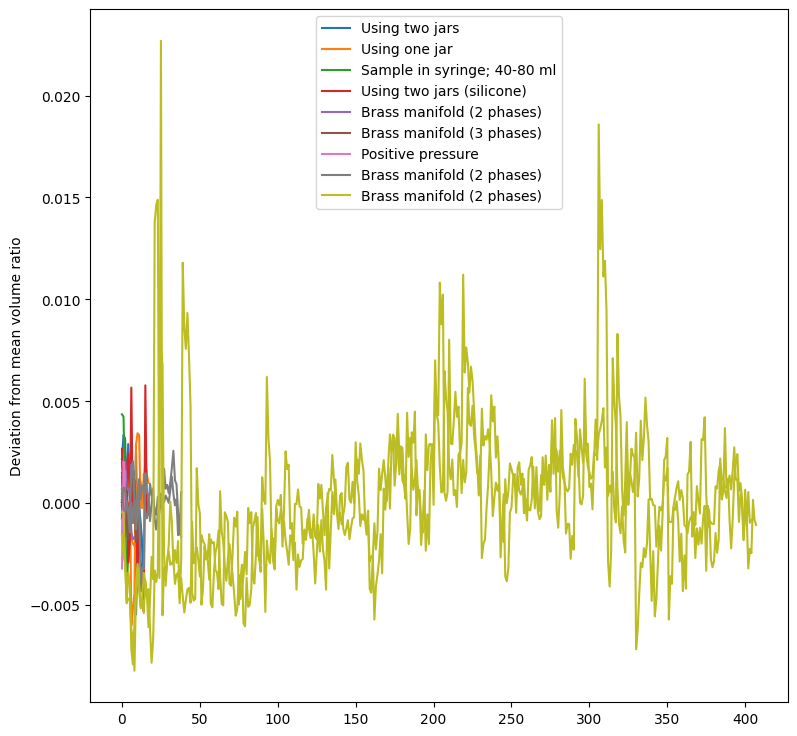

In [17]:
# Get calibration sample ids
cal_sample_ids = samples[~samples.volume.isna()].index

# Determine which trials to drop
id_mask = (trials.sample_id >= 248) & (trials.sample_id < 291)
cal_mask = [s in cal_sample_ids for s in trials.sample_id]
indices_to_drop = trials[id_mask & cal_mask].index

# Drop the trials
trials = trials.drop(indices_to_drop)

# Plot calibrations
plot_calibration()

There are some samples which were taken immediately after the beans were removed from the freezer. In hindsight it seems obvious, but it turns out that the volume measurements are very sensitive to temperature, as this has a major effect on the ideal gas law. Let's drop the samples in question.

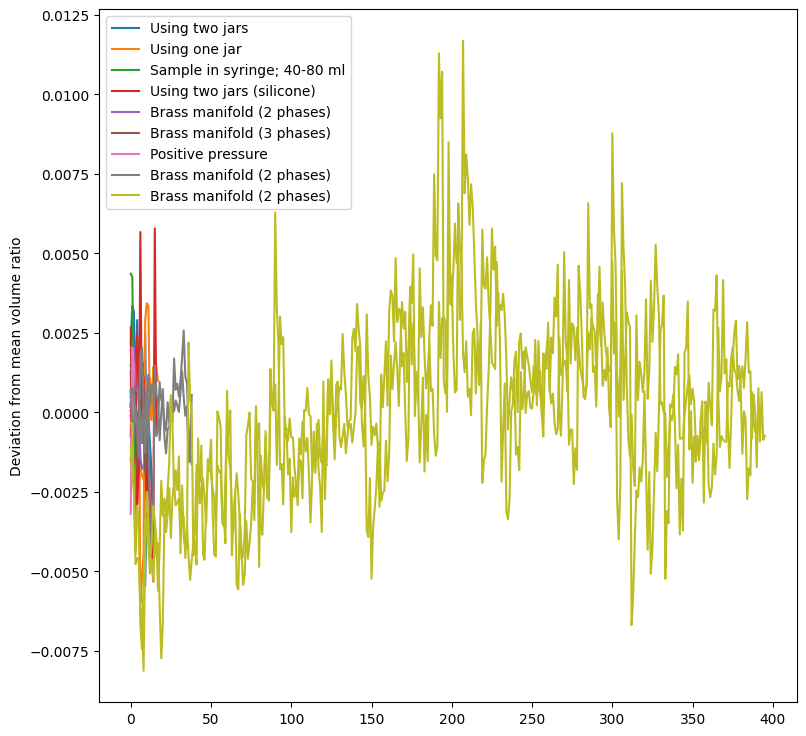

In [18]:
# Determine which trials to drop
samples_to_drop = [387, 395, 419, 421, 850, 851, 856, 857, # Empty
                   400]                                    # 75 balls (old)

# Drop the trials
trials = trials[[s not in samples_to_drop for s in trials.sample_id]]

# Plot calibrations
plot_calibration()

Looking at non-calibration trials, there are some trials on May 20, 2023, using the syringe, where I noticed the pressure with the plunger pushed in changed from one trial to the next.

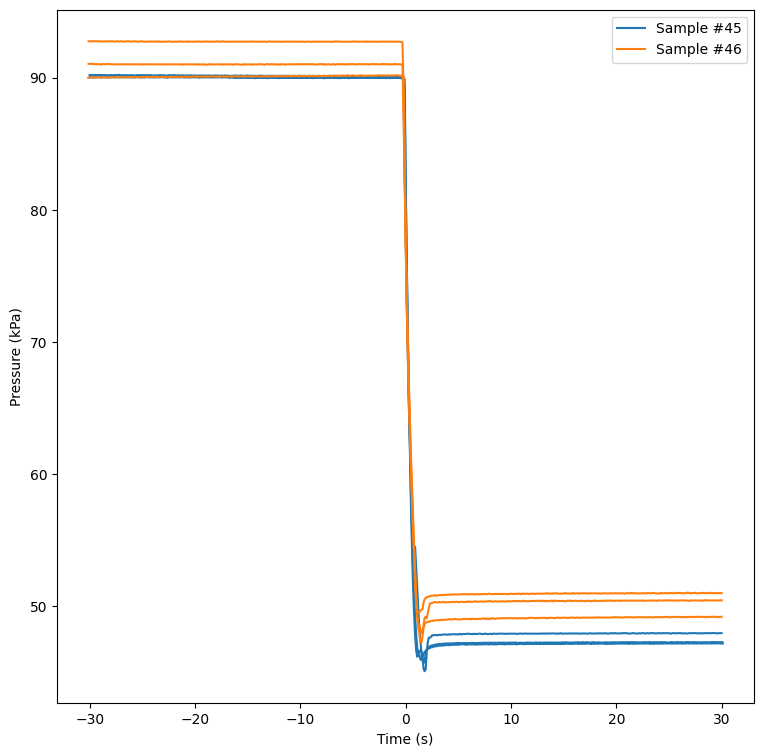

In [19]:
def plot_single_trial(index, color=None, label=None):
    # Read the data
    data = pd.read_csv(trials.loc[index].filename, header=0)

    # Plot data
    ax.plot(data.time, data.pres_1, c=color, label=label)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Get color map
colors = plt.colormaps['tab10'].colors

# Plot the trials
label = 'Sample #45'
for i in [133, 134, 135]:
    plot_single_trial(i, color=colors[0], label=label)
    label = None

label = 'Sample #46'
for i in [136, 137, 138]:
    plot_single_trial(i, color=colors[1], label=label)
    label = None

# Set axis labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pressure (kPa)')

# Draw legend
ax.legend(loc='upper right')

Each of these samples contains three trials which should be identical repetitions, but we see variation in the pressure change. There is no sign of leakage when the pluger is stationary, on either side of the transition, so in these cases I beleive the leakage was caused by the movement of the plunger.

In [20]:
# Drop the trials
trials = trials.drop([135, 137, 138])

There are some trials early on with the new gas pycnometer which seemed affected by an unknown glitch--maybe a bad USB power supply. Let's drop these.

In [21]:
# Drop the trials
trials = trials.drop([1172, 1180, 1181, 1311])

There are also some samples which were taken right after the beans were taken out of the freezer. Let's drop these as well.

In [22]:
# Drop the trials
trials = trials.drop(range(187, 199))
trials = trials.drop(range(2542, 2545))
trials = trials.drop(range(2560, 2563))
trials = trials.drop(range(2791,2794))

# Calibration

To calibrate the gas pycnometer, we take measurements either with the sample chamber empty, or with a sample of known volume in the chamber. For these experiments, the reference was a set of 3/8" steel balls whose volume was measured using water displacement.

Let's look at the spread in volume ratio measurements for the two references.

2 Empty 1.022013072370911 0.0025549592734913683 0.0003858967064766439
1 Empty 1.3607838814540008 0.0027754542803168926 0.0004922537933510687
3 Empty 1.0471640258658577 0.0036059667011231456 0.0003687365853612956
4 Empty 1.021770378858288 0.002700225350203795 0.0003883562821460414
4 75 balls (old) 0.7585658035600766 0.0024785675794325645 0.00029354362029493977
5 Empty 1.0131923413667634 0.0010685488401684544 0.0003955792896674095
5 75 balls (old) 0.7518334343206449 0.001318629543586353 0.0003036685885155607
6 Empty 1.0135362142076003 0.0009898472023012804 0.00039316018997286294
6 75 balls (old) 0.7509108209361691 0.0010493161892176155 0.00030062280904037474
7 Empty 0.998646486854871 0.00280526146287686 0.0004811725806581565
7 75 balls (old) 0.7424539936769383 0.0013325337277409724 0.0003807296457140988
8 Empty 1.014274312251431 0.0014161827687739677 0.00040070009118308754
8 75 balls (old) 0.7518543753373267 0.0007281590859884239 0.0003046727169820068
9 Empty 0.996431928788901 0.00304625

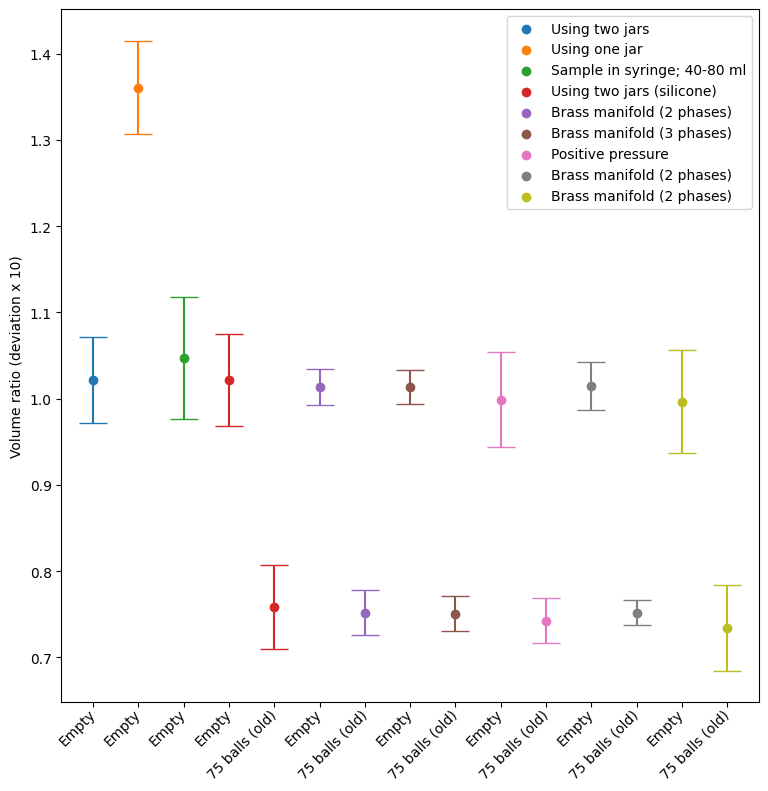

In [23]:
def rotate_tick_labels(ax, rotation=45, rotation_mode='anchor', 
                       horizontalalignment='right', verticalalignment='center'):
    for label in ax.get_xticklabels():
        label.set_rotation(rotation)
        label.set_rotation_mode(rotation_mode)
        label.set_horizontalalignment(horizontalalignment)
        label.set_verticalalignment(verticalalignment)

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Initialize ticks and labels
xticks = []
xlabels = []

for i, method_id in enumerate(samples.method_id.unique()):
    # Get samples for this method
    samples_this_method = samples_w_vol[samples_w_vol.method_id == method_id]
    
    # Initialize label
    label = methods.loc[method_id].description

    for description in ['Empty', '75 balls (old)']:
        # Get samples with this description
        samples_this_desc = samples_this_method[samples_this_method.description == description]
        
        # Get trials for these samples
        trials_this_desc = trials[[s in samples_this_desc.index for s in trials.sample_id]]
    
        if not trials_this_desc.empty:
            # Update ticks and labels
            x = len(xticks)
            xticks.append(x)
            xlabels.append(description)
            
            # Get volume ratios
            vol_ratios = trials_this_desc.vol_ratio

            # Get mean and deviation of volume ratio
            mean_vol_ratio = vol_ratios.mean()
            std_vol_ratio = vol_ratios.std()

            # Get mean value of the calculated sigma
            mean_sigma = trials_this_desc.sigma_vol_ratio.mean()
            
            # Print result
            print(method_id, description, mean_vol_ratio, std_vol_ratio, mean_sigma)

            # Plot data
            desc = methods.loc[method_id].description + ': ' + description
            ax.errorbar(x, mean_vol_ratio, yerr=std_vol_ratio * 19.6, 
                        fmt='none', capsize=10, color=colors[i])
            ax.scatter(x, mean_vol_ratio, color=colors[i], label=label)

            # Reset label
            label = None

# Set ticks and labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
            
# Set axis labels
ax.set_ylabel('Volume ratio (deviation x 10)')

# Rotate tick labels
rotate_tick_labels(ax)

# Draw the legend
plt.legend()

The uncertainty in these measurements is typically about 10 times the uncertainty calculated based on sensor resolution. So we know we are not limited by sensor resolution, but more likely by sensor accuracy or by unintended changes in the volume of the experimental setup.

To complete the calibration, for each method, we fit `volume` vs. `vol_ratio` with a line.

In [24]:
def volume_func(x, m, b):
    return m * x + b

# Intialize fits
vol_fits = {}

# Merge sample volume into trials
df = trials.merge(samples[['volume']], how='left', left_on='sample_id', right_index=True)

for method_id in samples.method_id.unique():
    # Get samples for this method
    samples_this_method = samples_w_vol[samples_w_vol.method_id == method_id]
    
    # Get trials for these samples
    trials_this_method = df[[s in samples_this_method.index for s in trials.sample_id]]

    # Get data for this method
    xs = trials_this_method.vol_ratio
    ys = trials_this_method.volume

    # Get the fit for this method
    vol_fits[method_id] = curve_fit(volume_func, xs, ys)

vol_fits

{np.int64(2): (array([-130.02492345,  132.89143776]),
  array([[ 0.15134378, -0.13486388],
         [-0.13486388,  0.12277251]])),
 np.int64(1): (array([-98.19633631, 133.6266513 ]),
  array([[ 0.04438552, -0.052485  ],
         [-0.052485  ,  0.06339539]])),
 np.int64(3): (array([-38.80144919,  40.63300283]),
  array([[ 0.03363558, -0.02931994],
         [-0.02931994,  0.02659388]])),
 np.int64(4): (array([-129.69103127,  132.46334088]),
  array([[ 0.05361767, -0.04459698],
         [-0.04459698,  0.0384101 ]])),
 np.int64(5): (array([-130.27085195,  131.99070576]),
  array([[ 0.07951653, -0.07017436],
         [-0.07017436,  0.06328779]])),
 np.int64(6): (array([-129.64518146,  131.40102802]),
  array([[ 0.04225726, -0.03728035],
         [-0.03728035,  0.03361829]])),
 np.int64(7): (array([-132.8818392 ,  132.70531705]),
  array([[ 0.86493934, -0.75297315],
         [-0.75297315,  0.66969623]])),
 np.int64(8): (array([-129.74455076,  131.59778658]),
  array([[ 0.015894  , -0.0140354

These lines give us a conversion from volume ratio to volume. Let's plot these fits.

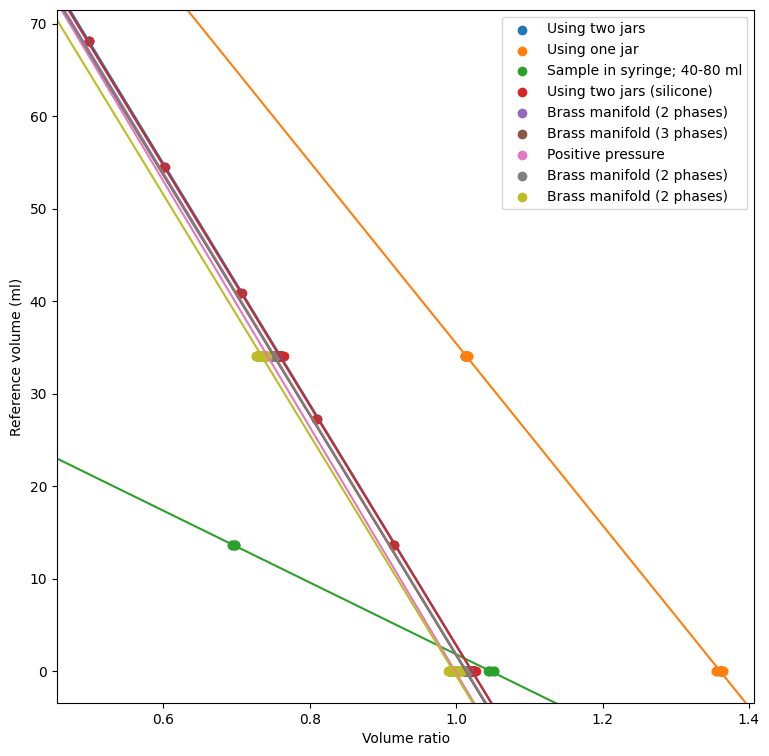

In [25]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for method_id in samples.method_id.unique():
    # Get samples for this method
    samples_this_method = samples_w_vol[samples_w_vol.method_id == method_id]
    
    # Get trials for these samples
    trials_this_method = df[[s in samples_this_method.index for s in trials.sample_id]]

    # Get data for this method
    xs = trials_this_method.vol_ratio
    ys = trials_this_method.volume

    # Plot the data
    ax.scatter(xs, ys, label=methods.loc[method_id].description)

# Get axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for method_id in samples.method_id.unique():
    # Get the fit for this method
    xs = np.linspace(*xlim)
    ys = volume_func(xs, *vol_fits[method_id][0])
    
    # Plot the fit
    ax.plot(xs, ys)

# Set axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axis labels
ax.set_xlabel('Volume ratio')
ax.set_ylabel('Reference volume (ml)')

# Draw the legend
plt.legend()

For the remainder of this analysis, we retain only samples for methods 4, 5, 6, and 8, as these produced the most accurate results.

In [26]:
# Keep samples with method 4, 5, 6, 8, 9
samples = samples[[m in [4, 5, 6, 8, 9] for m in samples.method_id]]

# Drop unused trials
trials = trials[[s in samples.index for s in trials.sample_id]]

# Variation in density between brands

Let's start by loading bag, brand, shot and depth information.

In [27]:
bags = pd.read_csv('bags.csv', index_col='id')
bags.tail()

,brand_id
id,
155,107
156,108
157,109
158,110
159,111


In [28]:
brands = pd.read_csv('brands.csv', index_col='id')
brands.tail()

,name
id,
107,Day Tripper
108,Rosso Decaf
109,Genji Challa
110,Kianyangi AA
111,Irineo Ramirez


In [29]:
depths = pd.read_csv('depths.csv', index_col='id')
depths.tail()

,bag_id,grinder_cal_id,basket_id,grind_setting,weight_in_basket,depth_below_rim
id,,,,,,
1458,159,14,5,2.0,18.01,13.28
1459,159,14,5,2.0,18.00,12.97
1460,159,14,5,2.0,17.99,13.45
1461,159,14,5,2.0,18.01,13.26
1462,159,14,5,2.4,17.98,13.15


In [30]:
baskets = pd.read_csv('baskets.csv', index_col='id')
baskets.tail()

,diameter,depth,volume,description
id,,,,
2,59.00,28.30,74.983333,Double basket that came with naked portafilter
4,58.65,23.35,61.450000,VST 18 g basket
5,58.74,25.26,66.903333,VST 20 g basket


Now we can calculate the volume and density of each trial using the linear fits calculated above.

In [31]:
def get_volume_and_density(row):
    sample = samples.loc[row.sample_id]
    vol_calc = volume_func(row.vol_ratio, *vol_fits[sample.method_id][0])
    density = sample.weight / vol_calc
    return pd.Series([vol_calc, density], index=['volume', 'density'])

trials[['volume', 'density']] = trials.apply(get_volume_and_density, axis = 1)
trials.tail()

,sample_id,filename,vol_ratio,sigma_vol_ratio,volume,density
id,,,,,,
2975,993,trials/trial-2975.csv,0.996081,0.000515,0.053402,0.000000
2976,993,trials/trial-2976.csv,0.995842,0.000515,0.084471,0.000000
2977,994,trials/trial-2977.csv,0.735132,0.000390,33.958972,7.927213
2978,994,trials/trial-2978.csv,0.733623,0.000391,34.155067,7.881700
2979,994,trials/trial-2979.csv,0.733760,0.000392,34.137210,7.885823


Let's create a list of bags sorted by bean density.

In [32]:
# Shortened labels
short_labels = {52: 'Tamana Varietales', 
                53: 'Tamana Caturron'}

# Initialize the list
bag_info = []

# Get unique bags
samples_w_bag = samples.dropna(subset='bag_id')

# Get bag ids
bag_ids = samples_w_bag.bag_id.unique()
bags_used = bags[[i in bag_ids for i in bags.index]]

# Sort bag_ids by bean density
for bag_id in bag_ids:
    # Get brand
    brand_id = bags.loc[bag_id].brand_id

    # Get label
    if brand_id in short_labels:
        bag_label = short_labels[brand_id]
    else:
        bag_label = brands.loc[brand_id]['name']

    # Handle brands with more than one bag
    if len(bags_used[bags_used.brand_id == brand_id]) > 1:
        bag_label += f' #{bag_id:.0f}'
    
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]

    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()

    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]

    if not bean_trials.empty:
        # Get average bean density
        density = bean_trials.density.mean()

        # Add to list
        bag_info.append((bag_id, bag_label, density))

# Sort the list by density
bag_info = sorted(bag_info, key=lambda x: x[2])

Now let's plot density for beans, ground coffee, and tamped coffee with a grind setting of 2.00.

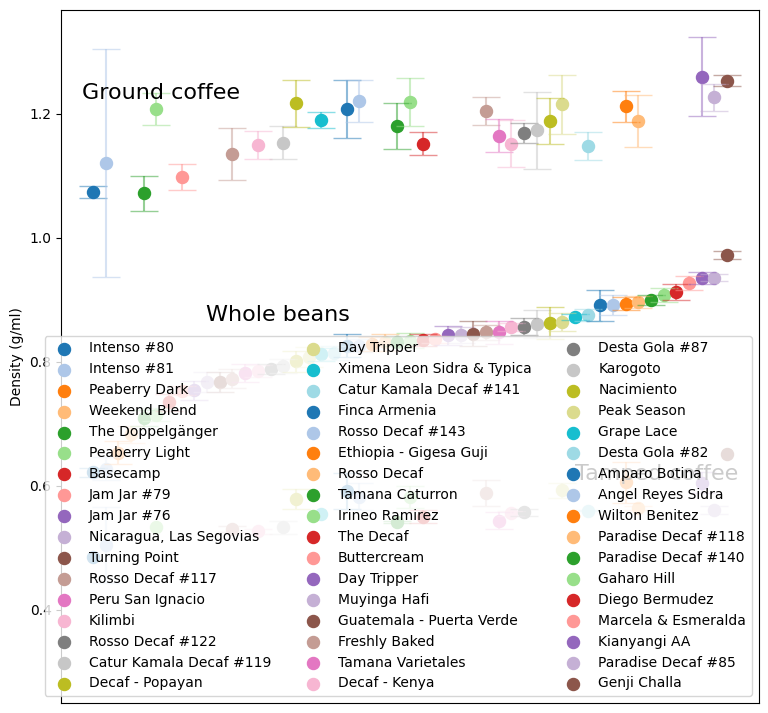

In [33]:
def get_volume(row):
    basket = baskets.loc[row.basket_id]
    return basket.volume - np.pi * (basket.diameter / 2)**2 * row.depth_below_rim / 1000
    
# Get color map
bag_colors = plt.colormaps['tab20'].colors + plt.colormaps['tab20'].colors + plt.colormaps['tab20'].colors

# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]

    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()

    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]

    if not bean_trials.empty:
        # Get trial densities
        densities = bean_trials.density

        # Calculate mean and standard deviation
        ys = densities.mean()
        yerrs = densities.std() * 1.96

        # Plot
        if len(densities) > 1:
            ax.errorbar(i, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(i, ys, color=bag_colors[i], label=label, s=75)
        
    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting & (samples_this_bag.grind_setting == 2.00)]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    if not ground_trials.empty:
        # Get trial densities
        densities = ground_trials.density

        # Calculate mean and standard deviation
        ys = densities.mean()
        yerrs = densities.std() * 1.96

        # Plot
        if len(densities) > 1:
            ax.errorbar(i, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(i, ys, color=bag_colors[i], s=75)

    # Get tamped densities
    depths_this_bag = depths[(depths.bag_id == bag_id) & (depths.grind_setting == 2.00)]

    if not depths_this_bag.empty:
        # Calculate densities
        volumes = depths_this_bag.apply(get_volume, axis=1)
        densities = depths_this_bag.weight_in_basket / volumes

        # Calculate mean and standard deviation
        ys = densities.mean()
        yerrs = densities.std() * 1.96

        # Plot
        if len(densities) > 1:
            ax.errorbar(i, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(i, ys, color=bag_colors[i], s=75)

# Add text labels
plt.text(0.03, 0.88, 'Ground coffee', fontsize=16, 
         horizontalalignment='left', verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.31, 0.56, 'Whole beans', fontsize=16, 
         horizontalalignment='center', verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.97, 0.33, 'Tamped coffee', fontsize=16, 
         horizontalalignment='right', verticalalignment='center', 
         transform=ax.transAxes)

# Set y limits
ylim = plt.ylim()
plt.ylim(ylim[0] - 0.15, ylim[1])

# Set ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Set axis labels
ax.set_ylabel('Density (g/ml)')

# Draw legend
plt.legend(loc='lower right', ncol=3)

What if we look at the density of ground coffee relative to the whole beans?

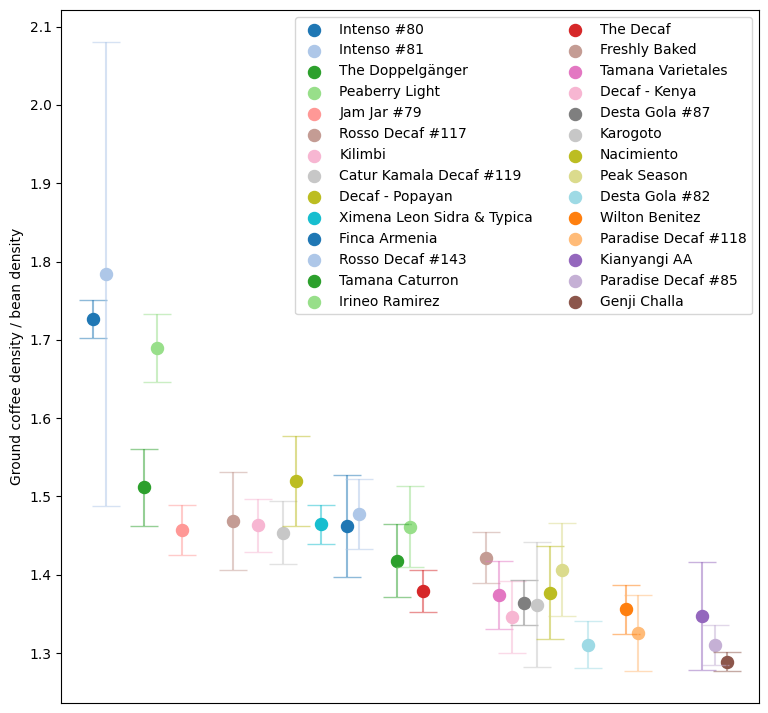

In [34]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]

    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()

    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]

    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting & (samples_this_bag.grind_setting == 2.00)]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    if not bean_trials.empty and not ground_trials.empty:
        # Get bean densities
        bean_densities = bean_trials.density

        # Get ground densities
        ground_densities = ground_trials.density

        # Calculate mean and standard deviation
        ys = ground_densities.mean() / bean_densities.mean()
        yerrs = np.sqrt((ground_densities.std() / bean_densities.mean())**2 + 
                        (ground_densities.mean() / bean_densities.mean()**2 * bean_densities.std())**2) * 1.96

        # Plot
        if len(bean_densities) > 1 and len(ground_densities) > 1:
            ax.errorbar(i, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(i, ys, color=bag_colors[i], label=label, s=75)

# Set ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Set axis labels
ax.set_ylabel('Ground coffee density / bean density')

# Draw legend
plt.legend(loc='upper right', ncol=2)

How about the density of the tamped puck vs. the ground coffee?

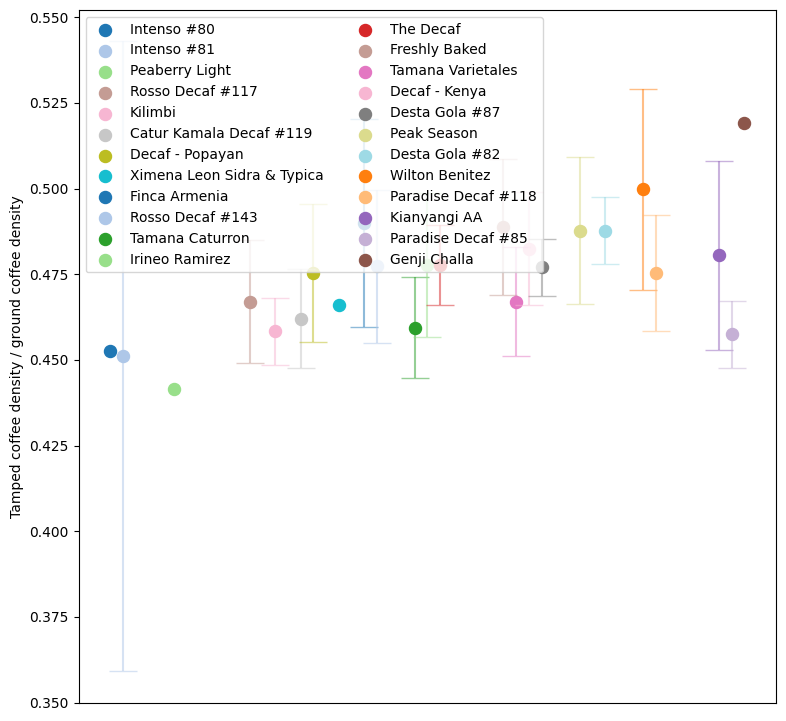

In [35]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]

    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()

    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting & (samples_this_bag.grind_setting == 2.00)]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    # Get depth measurements
    depths_this_bag = depths[(depths.bag_id == bag_id) & (depths.grind_setting == 2.00)]

    if not ground_trials.empty and not depths_this_bag.empty:
        # Get ground densities
        ground_densities = ground_trials.density

        # Calculate tamped densities
        volumes = depths_this_bag.apply(get_volume, axis=1)
        tamped_densities = depths_this_bag.weight_in_basket / volumes
        
        # Calculate mean and standard deviation
        ys = tamped_densities.mean() / ground_densities.mean()
        yerrs = np.sqrt((tamped_densities.std() / ground_densities.mean())**2 + 
                        (tamped_densities.mean() / ground_densities.mean()**2 * ground_densities.std())**2) * 1.96

        # Plot
        if len(ground_densities) > 1 and len(tamped_densities) > 1:
            ax.errorbar(i, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(i, ys, color=bag_colors[i], label=label, s=75)

# Set ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Set axis labels
ax.set_ylabel('Tamped coffee density / ground coffee density')

# Draw legend
plt.legend(loc='upper left', ncol=2)

# Variation in ground coffee density with grind setting

Above, we saw that the density of ground coffee relative to the density of the whole beans changes depending on the coffee. This measurement also changes within a single coffee, as grind setting changes. Rather than look at this change in terms of grind setting, in the analysis below I will convert to burr spacing using measurements made on my Specialita grinder. First, let's import those measurements.

In [36]:
grinder_cals = pd.read_csv('grinder_cals.csv', index_col='id')
grinder_cals.tail()

,date,grinder_id,zero_digits,um_per_digit,burr_angle,notes
id,,,,,,
4,NaN,1,0.1,47.0,0.0,Re-aligned grinder; https://quantitativecafe.c...
13,2024-06-23,3,-1.6,30.0,0.0,Used 5.0 in-lb torque on screws; cleaned pushi...
14,2024-08-11,3,-1.6,30.0,0.0,Used 5.0 in-lb torque on screws; cleaned and l...
15,2024-11-08,4,0.3,80.0,66.0,Touch point has drifted; actual burr touch at ...


Now let's calculate burr spacing from grind setting.

In [37]:
def get_burr_spacing(row):
    if not np.isnan(row.grinder_cal_id):
        grinder_cal = grinder_cals.loc[row.grinder_cal_id]
        burr_spacing = (row.grind_setting - grinder_cal.zero_digits) * grinder_cal.um_per_digit
    else:
        burr_spacing = np.nan
    return pd.Series([burr_spacing], index=['burr_spacing'])

samples['burr_spacing'] = samples.apply(get_burr_spacing, axis = 1)
samples.tail()

,date,weight,volume,bag_id,grinder_cal_id,grind_setting,shot_id,depth_id,method_id,description,notes,burr_spacing
id,,,,,,,,,,,,
990,2025-02-15,0.00,0.00,NaN,NaN,NaN,NaN,NaN,9,Empty,NaN,NaN
991,2025-02-15,269.35,34.05,NaN,NaN,NaN,NaN,NaN,9,75 balls (old),NaN,NaN
992,2025-02-16,18.32,NaN,159.0,14.0,2.4,1987.0,1462.0,9,Irineo Ramirez (2.40) ground,NaN,120.0
993,2025-02-16,0.00,0.00,NaN,NaN,NaN,NaN,NaN,9,Empty,NaN,NaN
994,2025-02-16,269.20,34.05,NaN,NaN,NaN,NaN,NaN,9,75 balls (old),NaN,NaN


Now let's plot normalized ground coffee density vs. burr spacing.

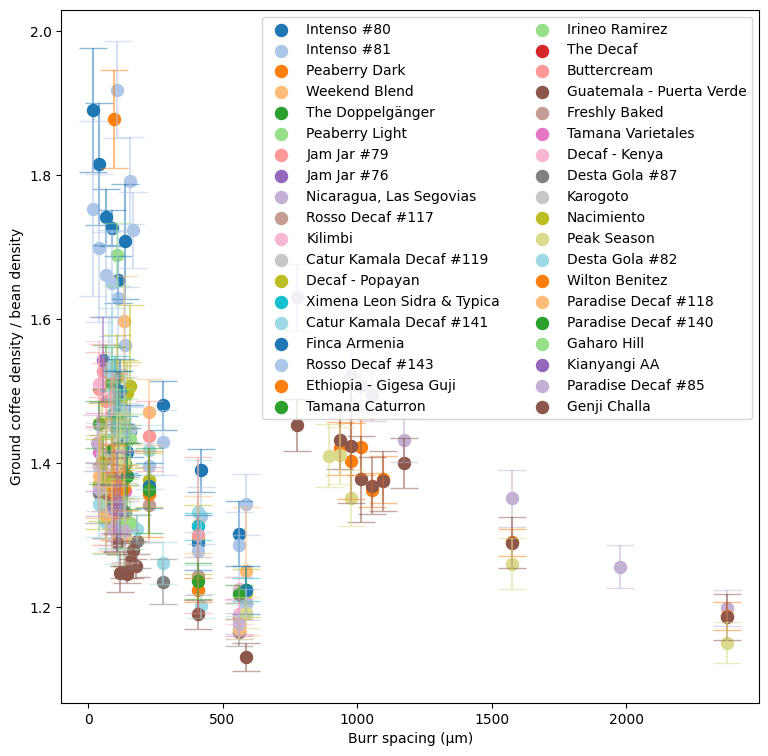

In [38]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]
    
    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    if not bean_trials.empty:
        # Get bean densities
        bean_densities_mean = bean_trials.density.mean()
        bean_densities_std = bean_trials.density.std()
        
        for burr_spacing in ground_samples.burr_spacing.unique():
            # Get samples for this grind setting
            samples_this_grind = samples_this_bag[samples_this_bag.burr_spacing == burr_spacing]
            trials_this_grind = trials[[s in samples_this_grind.index for s in trials.sample_id]]
        
            if not trials_this_grind.empty:
                # Get ground densities
                ground_densities = trials_this_grind.density
        
                # Calculate mean and standard deviation
                ys = ground_densities.mean() / bean_densities_mean
                yerrs = np.sqrt((ground_densities.std() / bean_densities_mean)**2 + 
                                (ground_densities.mean() / bean_densities_mean**2 * bean_densities_std)**2) * 1.96
        
                # Plot
                if len(ground_densities) > 1:
                    ax.errorbar(burr_spacing, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
                ax.scatter(burr_spacing, ys, color=bag_colors[i], label=label, s=75)
        
                # Reset label
                label = None

# Get plot limits
xlim = ax.set_xlim()
ylim = ax.get_ylim()

# Set axis labels
ax.set_xlabel('Burr spacing (µm)')
ax.set_ylabel('Ground coffee density / bean density')

# Draw legend
plt.legend(loc='upper right', ncol=2)

Both of these effects can be explained if we consider what happens when we cut a porous particle. When we do this, we expose some pores which were previously on the inside of the particle. This causes a loss of particle volume, as some pore space which was previously considered inside the particle is now considered part of the space between particles.

The amount of volume lost will be proportional to the total surface area of the cut particles. For very large particles with little surface area (like a bean), we will have a relatively small loss of volume, but as the particle size gets smaller an the surface area gets larger, this number will increase.

We can model this as:

$$
\rho = \frac{m}{V_0 - \Delta V} = \frac{1}{1 / \rho_0 - \Delta V / m} = \frac{1}{1 / \rho_0 - a S}
$$

Here, $\rho_0$ is the density of the porous material, $a$ is the amount of volume lost per unit of surface area, and $S$ is the specific surface area of the sample. Specific surface area will depend on the size and shape of the constituent particles. For a sample composed of spherical particles, we have:

$$
S = \frac{4 \pi r^2}{\rho_0 \cdot 4/3 \pi r^3} = \frac{3}{\rho_0 r} = \frac{6}{\rho_0 d}
$$

So:

$$
\rho = \frac{1}{1 / \rho_0 - 6 a / \rho_0 d} = \frac{\rho_0}{1 - 6 a / d}
$$

We don't know what grind setting would correspond with zero particle size, so we define this as $d_0$ and get:

$$
\frac{\rho}{\rho_0} = \frac{1}{1 - 6 a / (d - d_0)}
$$

Now, suppose that $d_0$ is a characteristic of the grinder, and $a$ is a characteristic of the bean. Then we can fit the data above to a family of curves of this form as follows.

In [39]:
# The model function
def density_func(d, d0, a):
    return 1 / (1 - 6 * a / (d - d0))

# Vectorized objective function
def objective(params, x_data, y_data, trial_indices):
    d0 = params[0]
    a_values = params[1:]
    residuals = []

    # Compute residuals for each trial
    for i in np.unique(trial_indices):
        indices = trial_indices == i
        x = x_data[indices]
        y = y_data[indices]
        a_i = a_values[i]
        y_pred = density_func(x, d0, a_i)
        residuals.extend(y - y_pred)
    
    return residuals

# Example data preparation
x_data = []
y_data = []
trial_indices = []
trial_bag_ids = []

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]
    
    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    if not bean_trials.empty:
        # Get bean densities
        bean_densities_mean = bean_trials.density.mean()
        bean_densities_std = bean_trials.density.std()
        
        # Initialize data
        xs = []
        ys = []
        
        for burr_spacing in ground_samples.burr_spacing.unique():
            # Get samples for this grind setting
            samples_this_grind = samples_this_bag[samples_this_bag.burr_spacing == burr_spacing]
            trials_this_grind = trials[[s in samples_this_grind.index for s in trials.sample_id]]
        
            if not trials_this_grind.empty:
                # Get ground densities
                ground_densities = trials_this_grind.density
        
                # Append data
                xs.append(burr_spacing)
                ys.append(ground_densities.mean() / bean_densities_mean)

        if len(xs):
            x_data.extend(xs)
            y_data.extend(ys)
            trial_indices.extend([len(trial_bag_ids)] * len(xs))
            trial_bag_ids.append(bag_id)

x_data = np.array(x_data)
y_data = np.array(y_data)
trial_indices = np.array(trial_indices)

# Initial guess for the parameters
initial_guess = [-10] + [1e-3] * len(trial_bag_ids)

# Perform the fitting
result = least_squares(objective, initial_guess, args=(x_data, y_data, trial_indices))

d0_estimated = result.x[0]
a_estimated = result.x[1:]

print("Estimated d0:", d0_estimated)
print("Estimated a values:", a_estimated)

Estimated d0: -728.8021022294355
Estimated a values: [57.19263358 55.93632558 64.24475738 50.73295912 46.10316128 56.92315872
 43.99376047 46.07346897 97.00805078 43.50221617 42.97656834 42.57261719
 46.78789844 44.38270367 47.00668273 44.16781722 44.7243409  82.7279593
 39.60680738 44.28962388 37.51894548 45.54702109 82.37534486 40.34522009
 37.15228641 34.42458104 34.41321519 36.63759541 36.2145642  45.59607564
 33.08797358 37.77126851 33.60151951 40.20060973 34.39186247 35.34505931
 34.7206351  29.91668856]


It's interesting that the values of $a$ here are on the order of 30-50 µm. This is approximately the diameter of macropores in roasted coffee (20-40 µm)[1]. This suggests that the "lost volume" may be due to internal pores being exposed by the grinding process, so that they no longer form part of the volume of the particles, but rather part of the volume between particles.

Let's plot these fits.

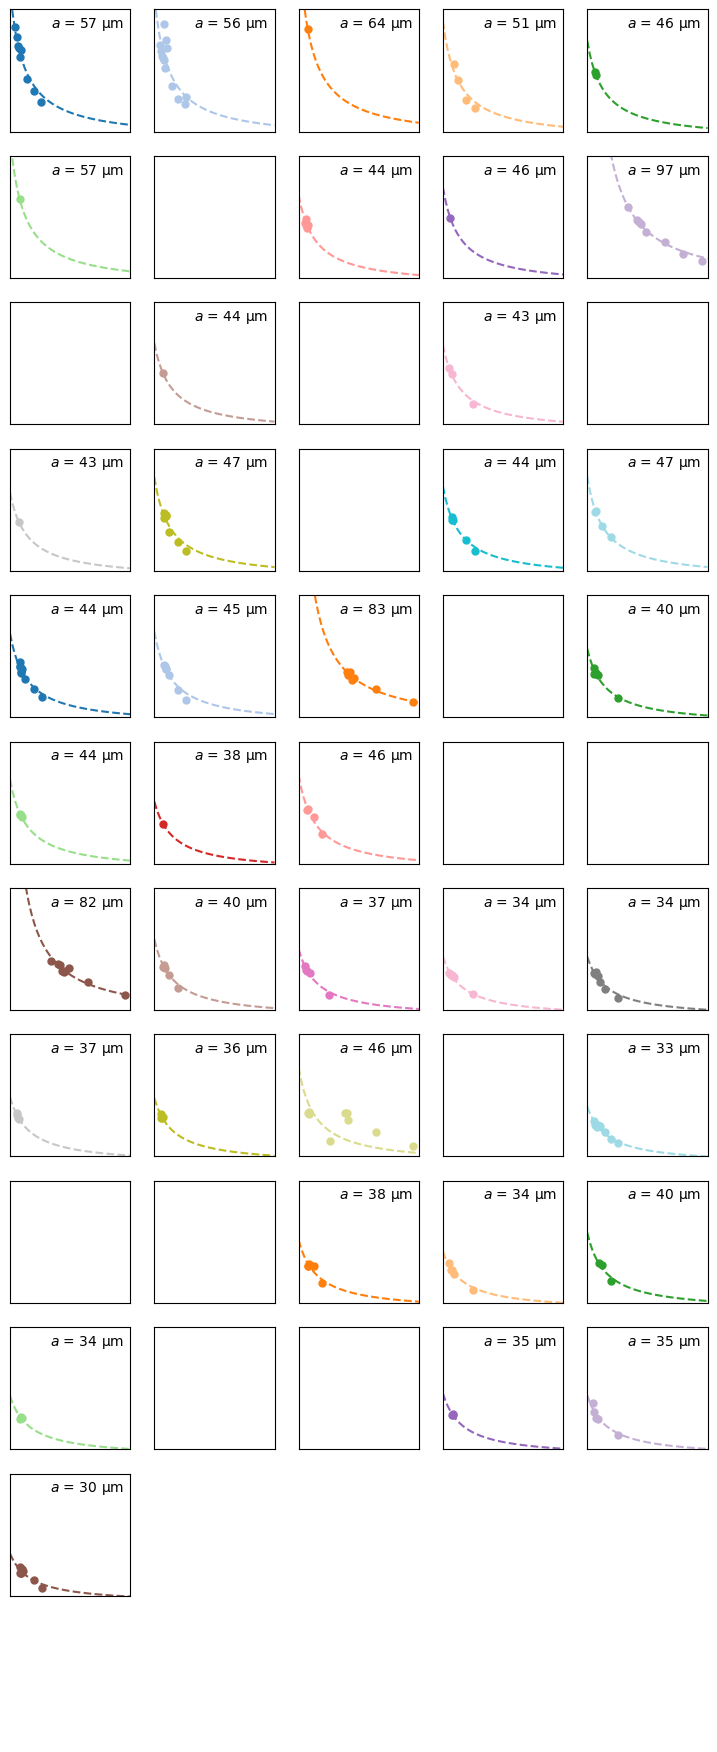

In [40]:
# Create the figure
fig, axs = plt.subplots(nrows=12, ncols=5, figsize=(9,22.5))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get axis for this bag
    ax = axs[int(i / 5), i % 5]
    
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]
    
    # Get ground trials
    ground_samples = samples_this_bag[has_grind_setting]
    ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]

    if not bean_trials.empty:
        # Get bean densities
        bean_densities_mean = bean_trials.density.mean()
        bean_densities_std = bean_trials.density.std()
        
        for burr_spacing in ground_samples.burr_spacing.unique():
            # Get samples for this grind setting
            samples_this_grind = samples_this_bag[samples_this_bag.burr_spacing == burr_spacing]
            trials_this_grind = trials[[s in samples_this_grind.index for s in trials.sample_id]]
        
            if not trials_this_grind.empty:
                # Get ground densities
                ground_densities = trials_this_grind.density
        
                # Calculate mean and standard deviation
                ys = ground_densities.mean() / bean_densities_mean
        
                # Plot
                ax.scatter(burr_spacing, ys, color=bag_colors[i], label=label, s=25)
        
                # Reset label
                label = None

    if bag_id in trial_bag_ids:
        # Get fit index
        k = trial_bag_ids.index(bag_id)
        
        # Plot the fit
        xs = np.linspace(*xlim)
        ys = density_func(xs, d0_estimated, a_estimated[k])
        ax.plot(xs, ys, ls='--', color=bag_colors[i])
        
        # Add parameter to plot
        plt.text(0.95, 0.95, f'$a$ = {a_estimated[k]:.0f} µm', fontsize=10, 
                 horizontalalignment='right', verticalalignment='top', 
                 transform=ax.transAxes)
    
    # Hide ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Set plot limits
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# Hide unused axes
for i in range(i+1, 60):
    axs[int(i / 5), i % 5].axis('off')

Now let's plot the thickness of the surface layer, $a$, vs. bean specific volume.

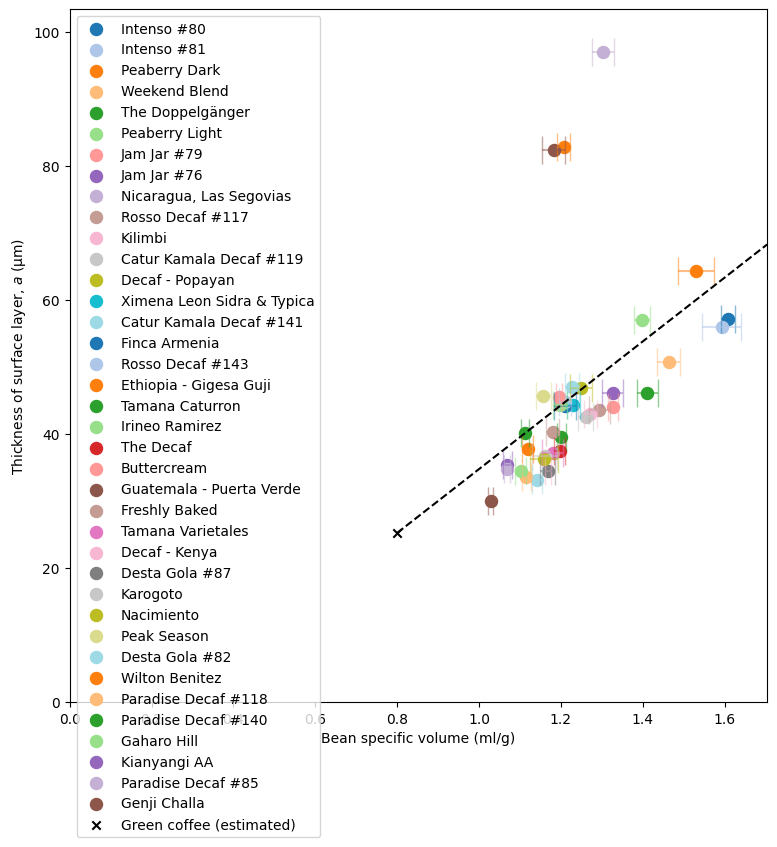

In [41]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

# Initialize data
xs = []
ys = []

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]

    if bag_id in trial_bag_ids and not bean_trials.empty:
        # Get fit index
        k = trial_bag_ids.index(bag_id)

        # Get bean densities
        bean_volumes_mean = (1 / bean_trials.density).mean()
        bean_volumes_std = (1 / bean_trials.density).std()

        # Save data
        xs.append(bean_volumes_mean)
        ys.append(a_estimated[k])

        ax.errorbar(bean_volumes_mean, a_estimated[k], xerr=bean_volumes_std * 1.96, 
                    fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
        ax.scatter(bean_volumes_mean, a_estimated[k], color=bag_colors[i], label=label, 
                   marker='o', s=75)

# Set axis ranges
xlim = (0, plt.xlim()[1] * 1.02)
ylim = (0, plt.ylim()[1] * 1.03)

plt.xlim(*xlim)
plt.ylim(*ylim)

def roast_func(x, m, b):
    return m * x + b

# Get curve fit
params, cov = curve_fit(roast_func, xs, ys)

# Plot point for green coffee
x_green = 1000. / 1250
y_green = roast_func(x_green, *params)
ax.scatter(x_green, y_green, color='k', label='Green coffee (estimated)', marker='x')

# Plot the fit
xs = np.linspace(x_green, xlim[1])
ys = roast_func(xs, *params)
ax.plot(xs, ys, ls='--', color='k')

# Set axis labels
ax.set_xlabel('Bean specific volume (ml/g)')
ax.set_ylabel('Thickness of surface layer, $a$ (µm)')

# Draw legend
plt.legend()

The dashed line shows a linear fit to the data. This might form a trajectory along which coffee travels during the roasting process. The black "x" shows where green coffee, with a particle density of about 1250 kg/m^3[2], would fall on that trajectory.

# Variation in tamped coffee density with grind setting

We start by calculating burr spacing for each measurement.

In [42]:
def get_burr_spacing(row):
    if not np.isnan(row.grinder_cal_id):
        grinder_cal = grinder_cals.loc[row.grinder_cal_id]
        burr_spacing = (row.grind_setting - grinder_cal.zero_digits) * grinder_cal.um_per_digit
    else:
        burr_spacing = np.nan
    return pd.Series([burr_spacing], index=['burr_spacing'])

depths['burr_spacing'] = depths.apply(get_burr_spacing, axis = 1)
depths.tail()

,bag_id,grinder_cal_id,basket_id,grind_setting,weight_in_basket,depth_below_rim,burr_spacing
id,,,,,,,
1458,159,14,5,2.0,18.01,13.28,108.0
1459,159,14,5,2.0,18.00,12.97,108.0
1460,159,14,5,2.0,17.99,13.45,108.0
1461,159,14,5,2.0,18.01,13.26,108.0
1462,159,14,5,2.4,17.98,13.15,120.0


Then we plot normalized tamped coffee density vs. burr spacing.

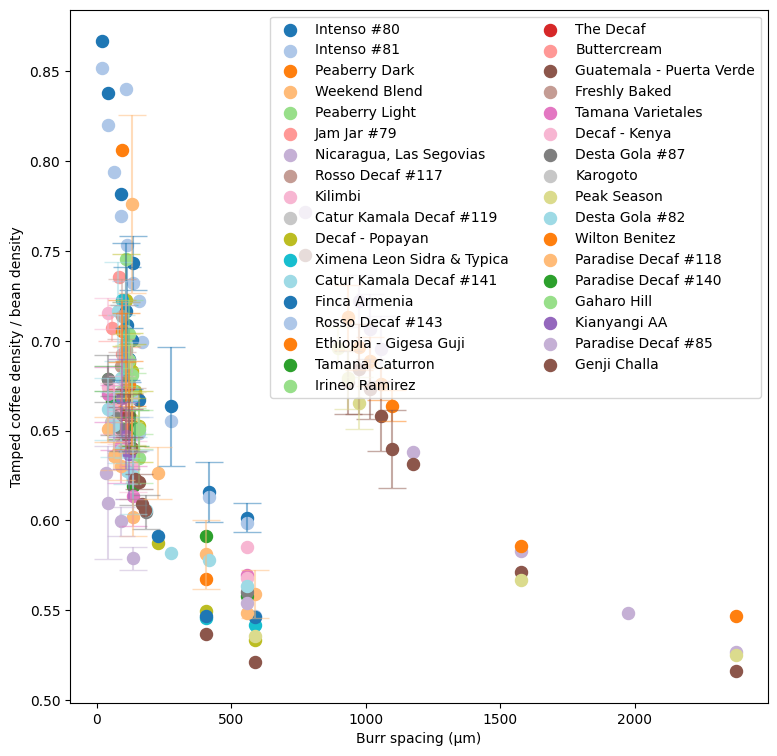

In [43]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get depths for this bag
    depths_this_bag = depths[depths.bag_id == bag_id]

    # Get bean trials
    bean_samples = samples_this_bag[~has_grind_setting]
    bean_trials = trials[[s in bean_samples.index for s in trials.sample_id]]
    
    if not depths_this_bag.empty and not bean_trials.empty:
        # Get bean densities
        bean_densities_mean = bean_trials.density.mean()
        bean_densities_std = bean_trials.density.std()

        for burr_spacing in depths_this_bag.burr_spacing.unique():
            # Get depth measurements
            depths_this_grind = depths_this_bag[depths_this_bag.burr_spacing == burr_spacing]
        
            if not depths_this_grind.empty:
                # Calculate tamped densities
                volumes = depths_this_grind.apply(get_volume, axis=1)
                tamped_densities = depths_this_grind.weight_in_basket / volumes
                
                # Calculate mean and standard deviation
                ys = tamped_densities.mean() / bean_densities_mean
                yerrs = np.sqrt((tamped_densities.std() / bean_densities_mean)**2 + 
                                (tamped_densities.mean() / bean_densities_mean**2 * bean_densities_std)**2) * 1.96
        
                # Plot
                if len(depths_this_grind) > 1:
                    ax.errorbar(burr_spacing, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
                ax.scatter(burr_spacing, ys, color=bag_colors[i], label=label, s=75)
        
                # Reset label
                label = None

# Get plot limits
xlim = ax.set_xlim()
ylim = ax.get_ylim()

# Set axis labels
ax.set_xlabel('Burr spacing (µm)')
ax.set_ylabel('Tamped coffee density / bean density')

# Draw legend
plt.legend(loc='upper right', ncol=2)

What if we plot tamped coffee density divided by ground coffee density vs. burr spacing?

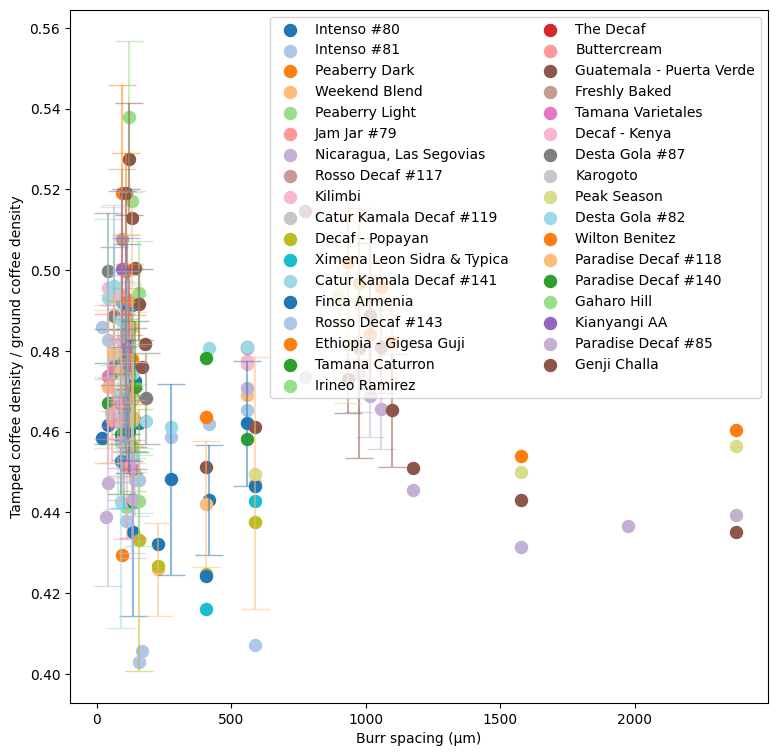

In [44]:
# Create the figure
fig, ax = plt.subplots(figsize=(9,9))
fig.patch.set_facecolor('white')

for i, (bag_id, label, _) in enumerate(bag_info):
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get depths for this bag
    depths_this_bag = depths[depths.bag_id == bag_id]

    for burr_spacing in depths_this_bag.burr_spacing.unique():
        # Get depth measurements
        depths_this_grind = depths_this_bag[depths_this_bag.burr_spacing == burr_spacing]
    
        # Get ground trials
        ground_samples = samples_this_bag[has_grind_setting & (samples_this_bag.burr_spacing == burr_spacing)]
        ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]
        
        if not depths_this_grind.empty and not ground_trials.empty:
            # Get ground densities
            ground_densities = ground_trials.density
            
            # Calculate tamped densities
            volumes = depths_this_grind.apply(get_volume, axis=1)
            tamped_densities = depths_this_grind.weight_in_basket / volumes
            
            # Calculate plot values
            ys = tamped_densities.mean() / ground_densities.mean()
            yerrs = np.sqrt((tamped_densities.std() / ground_densities.mean())**2 + 
                            (tamped_densities.mean() / ground_densities.mean()**2 * ground_densities.std())**2) * 1.96

            # Plot
            if len(ground_densities) > 1 and len(tamped_densities) > 1:
                ax.errorbar(burr_spacing, ys, yerr=yerrs, fmt='none', capsize=10, color=bag_colors[i], alpha=0.5)
            ax.scatter(burr_spacing, ys, color=bag_colors[i], label=label, s=75)
    
            # Reset label
            label = None

# Get plot limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Set axis labels
ax.set_xlabel('Burr spacing (µm)')
ax.set_ylabel('Tamped coffee density / ground coffee density')

# Draw legend
plt.legend(loc='upper right', ncol=2)

Let's split these into separate subplots.

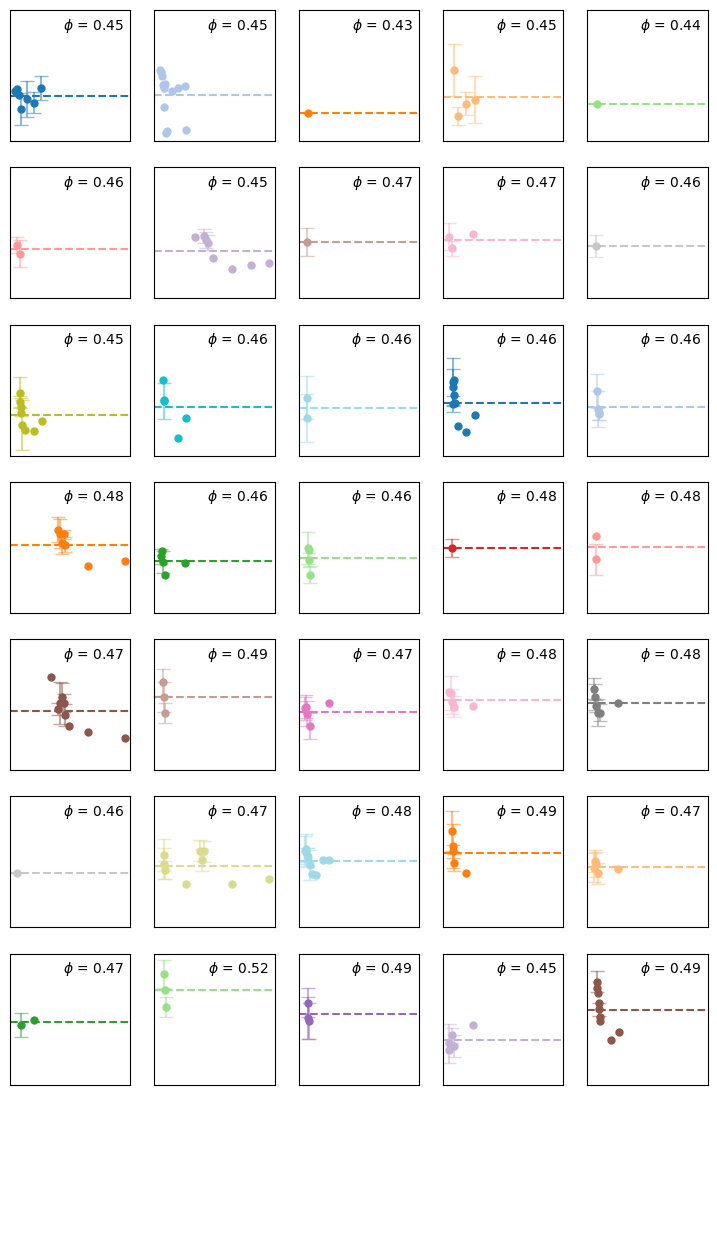

In [45]:
# Create the figure
fig, axs = plt.subplots(nrows=8, ncols=5, figsize=(9,16))
fig.patch.set_facecolor('white')

k = 0
for i, (bag_id, label, _) in enumerate(bag_info):
    # Get axis for this bag
    ax = axs[int(k / 5), k % 5]
    
    # Get samples for this bag
    samples_this_bag = samples[samples.bag_id == bag_id]
    
    # Separate into beans and ground coffee
    has_grind_setting = ~samples_this_bag.grind_setting.isna()
    
    # Get depths for this bag
    depths_this_bag = depths[depths.bag_id == bag_id]

    # Initialize value list
    vals = []

    for burr_spacing in depths_this_bag.burr_spacing.unique():
        # Get depth measurements
        depths_this_grind = depths_this_bag[depths_this_bag.burr_spacing == burr_spacing]
    
        # Get ground trials
        ground_samples = samples_this_bag[has_grind_setting & (samples_this_bag.burr_spacing == burr_spacing)]
        ground_trials = trials[[s in ground_samples.index for s in trials.sample_id]]
        
        if not depths_this_grind.empty and not ground_trials.empty:
            # Get ground densities
            ground_densities = ground_trials.density
            
            # Calculate tamped densities
            volumes = depths_this_grind.apply(get_volume, axis=1)
            tamped_densities = depths_this_grind.weight_in_basket / volumes
            
            # Calculate plot values
            ys = tamped_densities.mean() / ground_densities.mean()
            yerrs = np.sqrt((tamped_densities.std() / ground_densities.mean())**2 + 
                            (tamped_densities.mean() / ground_densities.mean()**2 * ground_densities.std())**2) * 1.96

            # Plot
            if len(ground_densities) > 1 and len(tamped_densities) > 1:
                ax.errorbar(burr_spacing, ys, yerr=yerrs, fmt='none', capsize=5, color=bag_colors[i], alpha=0.5)
            ax.scatter(burr_spacing, ys, color=bag_colors[i], label=label, s=25)

            # Append to values list
            vals.append(ys)
    
            # Reset label
            label = None

    if len(vals):
        # Calculate average
        avg = np.array(vals).mean()

        # Plot average
        xs = np.linspace(*xlim)
        ys = np.array([avg] * len(xs))
        ax.plot(xs, ys, ls='--', color=bag_colors[i])
        
        # Add average to plot
        plt.text(0.95, 0.95, f'$\\phi$ = {avg:.2f}', fontsize=10, 
                 horizontalalignment='right', verticalalignment='top', 
                 transform=ax.transAxes)
    
        # Hide ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        
        # Set plot limits
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

        # Increment plot counter
        k += 1

# Hide unused axes
for k in range(k, 40):
    axs[int(k / 5), k % 5].axis('off')

# References

[1] https://doi.org/10.1111/j.1365-2621.2000.tb16026.x \
[2] https://ecommons.cornell.edu/items/4cc57a66-8663-485c-bbc8-c36a6a610fc0